### _Activity feature extractor using pretrained models : C3D & KTH_
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Using pretrained activity recognition models for extracting action features from a video <br>
Pretrained model couresty: https://github.com/imatge-upc/activitynet-2016-cvprw

In [1]:
## Imports
import numpy as np
import cv2
import os
from keras import backend as K
K.set_learning_phase(1) #set learning phase
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPooling2D, Input, Concatenate,MaxPooling3D, Reshape, ZeroPadding3D
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import numpy as np
import pylab as plt
import keras
import h5py
import keras.backend as K

## Custom scripts
import lscript as lsp
import dataset as dset
import modelling as md

Using TensorFlow backend.


In [6]:
## Defining variables
time_step=50 # Sequence length
imagefolderpath= ('/nobackup/leopauly/KTH_new/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath)) # Checking if directory of video dataset exists
LOG_DIR='./logdir'
custom_global_step=0
nb_classes=3
lr_rate=.0005
batch_size = 5
height=150
width=300
channel=1
lstm_h_units=10
cluster_length=10
num_clusters=5
feature_size=487

True


#### Preparing the pretrained model

In [7]:
## Defining placeholders in tf
data = tf.placeholder(tf.float32, [None, cluster_length, height, width, channel]) #step_size=No: of frames in video sequence
target = tf.placeholder(tf.float32, [None, nb_classes])

In [8]:
## Suggested Network structure: C3D nework
model=md.modelC3D(cluster_length, height, width, channel, load_weights=False)
#model=keras.model.load_model('/nobackup/leopauly/c3d-sports1M_weights.h5')
feature_out=model([data])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 150, 300, 1)   0         
_________________________________________________________________
conv1 (Conv3D)               (None, 10, 150, 300, 64)  1792      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 10, 75, 150, 64)   0         
_________________________________________________________________
conv2 (Conv3D)               (None, 10, 75, 150, 128)  221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 5, 37, 75, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 5, 37, 75, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 5, 37, 75, 256)    1769728   
__________

#### Loading and displaying data

#### Extracting features 

In [9]:
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)

extraction_batch_size=1
x,y=dset.batch_gen_train(nb_classes,extraction_batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
x =x.reshape(x.shape[0],x.shape[1],height,width,channel)

(5, 10, 150, 300, 1)
label:0.0
Video_seq shape: (5, 10, 150, 300) Label shape (5,)


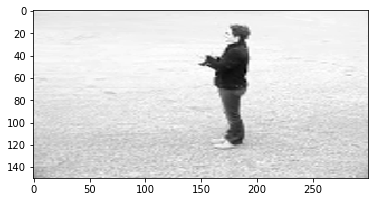

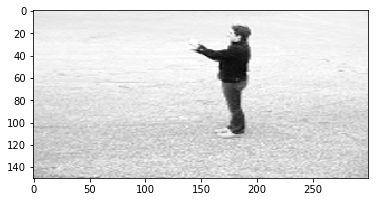

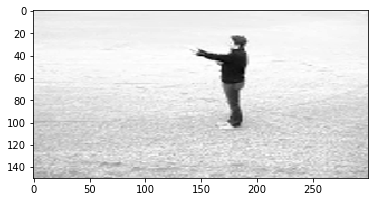

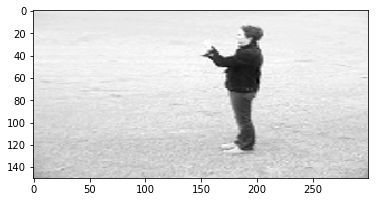

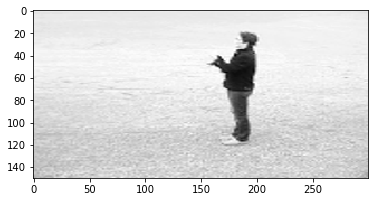

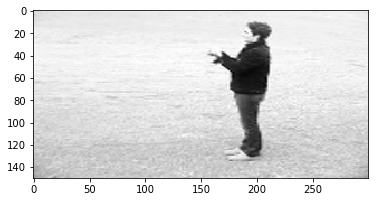

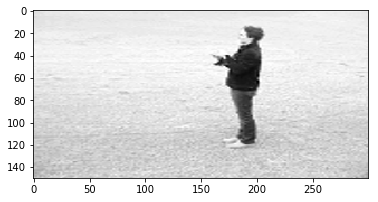

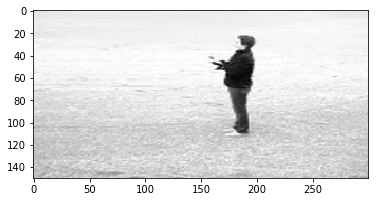

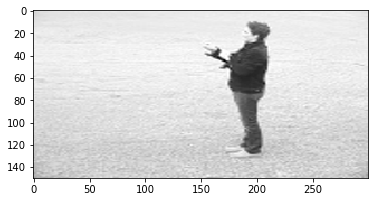

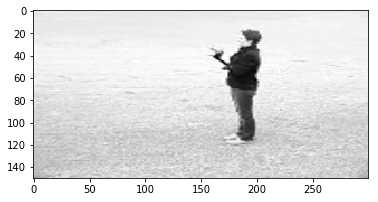

In [ ]:
## Splitting into & displaying clusters
clusters=dset.cluster_generator(x,num_clusters,cluster_length,height,width,channel)
item_num=2
y=np.zeros(num_clusters) # this lables are irrelevant
display=clusters.reshape(clusters.shape[0],clusters.shape[1],clusters.shape[2],clusters.shape[3])
lsp.view_video_seq(display,y,cluster_length,item_num)

In [ ]:
print('shape of clustered data:',clusters.shape)
features=np.zeros([num_clusters,feature_size])
for i in range(num_clusters):
    t=clusters[i].reshape(1,cluster_length,height,width,channel)
    print('shape of one cluster :',t.shape)
    features[i]= sess.run(feature_out,feed_dict={data:t})
    #print(features)
print(features.shape)

shape of clustered data: (5, 10, 150, 300, 1)
shape of one cluster : (1, 10, 150, 300, 1)


In [ ]:
#sess.close()